# Initial Imports

In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## MAKE A CNN


# Load in Data 

In [34]:

malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

# Merge data files into single DataFrame

In [35]:
malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6387 entries, 0 to 6386
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          6387 non-null   int64  
 1   Twitter ID              4664 non-null   float64
 2   Related Online Post ID  1177 non-null   float64
 3   Source ID               6387 non-null   object 
 4   Online Post Text        1723 non-null   object 
 5   Subjectivity            6387 non-null   int64  
 6   Sentiment Polarity      6387 non-null   object 
 7   Emotion                 6387 non-null   object 
 8   Sarcasm                 6387 non-null   int64  
 9   Irony                   6387 non-null   int64  
 10  Negation                6387 non-null   int64  
 11  Off-topic               6387 non-null   int64  
 12  Language                6387 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 648.8+ KB


# Clean up of data columns 

In [36]:
clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [37]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 5072
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  1114 non-null   int64 
 1   Text                1114 non-null   object
 2   Subjectivity        1114 non-null   int64 
 3   Sentiment Polarity  1114 non-null   object
 4   Emotion             1114 non-null   object
 5   Sarcasm             1114 non-null   int64 
 6   Irony               1114 non-null   int64 
 7   Negation            1114 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 78.3+ KB


# Emotion data Exploration

In [38]:
clean_data["Emotion"].value_counts()

Emotion
disgust         253
anger           225
anticipation    199
sadness         138
joy              95
surprise         92
trust            67
fear             45
Name: count, dtype: int64

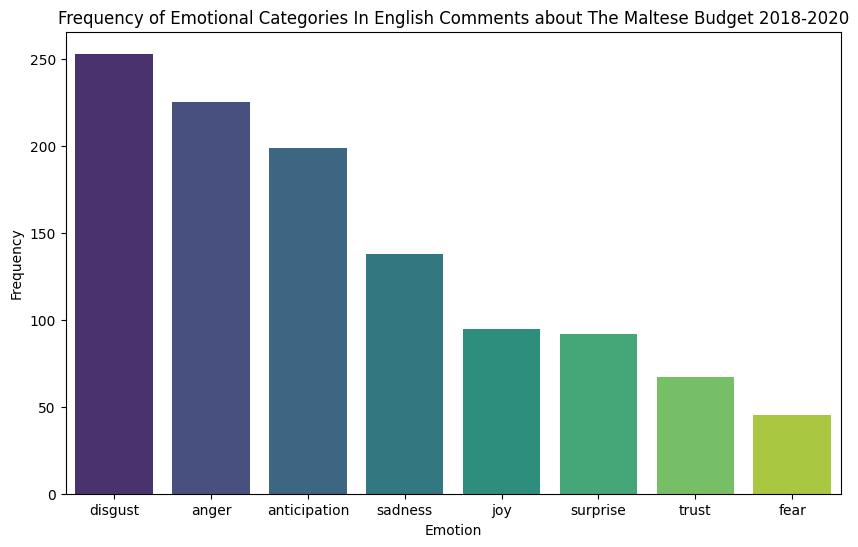

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

value_counts = clean_data['Emotion'].value_counts()

# Plotting the frequency of string values in the 'Category' column
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis', hue=value_counts.index, legend=False)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Frequency of Emotional Categories In English Comments about The Maltese Budget 2018-2020')
plt.show()

# Pre Processing of Text

In [40]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
clean_data['Text'] = clean_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
clean_data['Text'] = clean_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
clean_data['Text'] = clean_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
clean_data['Text'] = clean_data['Text'].str.lower()

# Remove punctuation
clean_data['Text'] = clean_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
clean_data['Text'] = clean_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
clean_data['Text'] = clean_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
clean_data['Text'] = clean_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
clean_data['Text'] = clean_data['Text'].str.strip()
clean_data['Text'] = clean_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
clean_data['Text'] = clean_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# clean_data['tokens'] = clean_data['Text'].apply(word_tokenize)
 
clean_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1


In [41]:
stripped_data = clean_data.drop(columns=['Subjectivity','Sentiment Polarity', 'Sarcasm','Irony','Negation'])
stripped_data.head()

,ID,Text,Emotion
0,20180001,great budget even cigarette touched great work...,trust
1,20180002,exactly scanned budget throughout earth make i...,disgust
2,20180003,already smoking cessation program people want ...,anticipation
3,20180004,alcohol fuel private vehicle raising tax cigar...,sadness
4,20180005,practical say third world country supposed eur...,anger


# Multinomial Naive Bayes

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

train_df, test_df = train_test_split(stripped_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['Text'])
X_test = vectorizer.transform(test_df['Text'])

# Labels
y_train = train_df['Emotion']
y_test = test_df['Emotion']

# Training Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Predicting on test data
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.28699551569506726
Classification Report:
               precision    recall  f1-score   support

       anger       0.19      0.31      0.24        45
anticipation       0.43      0.45      0.44        40
     disgust       0.32      0.51      0.39        51
        fear       0.50      0.11      0.18         9
         joy       0.00      0.00      0.00        19
     sadness       0.29      0.18      0.22        28
    surprise       0.00      0.00      0.00        18
       trust       0.00      0.00      0.00        13

    accuracy                           0.29       223
   macro avg       0.22      0.20      0.18       223
weighted avg       0.25      0.29      0.25       223



# CNN

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

# Tokenization and Padding
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(stripped_data['Text'])
sequences = tokenizer.texts_to_sequences(stripped_data['Text'])
x_data = pad_sequences(sequences, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_14         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1653 - loss: 2.0289 - val_accuracy: 0.2287 - val_loss: 1.9030
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2514 - loss: 1.8765 - val_accuracy: 0.1614 - val_loss: 1.8990
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3165 - loss: 1.7833 - val_accuracy: 0.2377 - val_loss: 1.8667
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5786 - loss: 1.4613 - val_accuracy: 0.1794 - val_loss: 1.8679
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7309 - loss: 0.9369 - val_accuracy: 0.2422 - val_loss: 1.9366
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8989 - loss: 0.5338 - val_accuracy: 0.2511 - val_loss: 2.1165
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9488 - loss: 0.2675 - val_accuracy: 0.2242 - val_loss: 2.3059
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9780 - loss: 0.1467 - val_accuracy: 0.2242 - v

# CNN with One Hot Encoding 

In [44]:
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_15         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1772 - loss: 2.0203 - val_accuracy: 0.2287 - val_loss: 1.9102
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3021 - loss: 1.8859 - val_accuracy: 0.1794 - val_loss: 1.9107
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4457 - loss: 1.7594 - val_accuracy: 0.1928 - val_loss: 1.8895
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5618 - loss: 1.4322 - val_accuracy: 0.2108 - val_loss: 1.8702
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7172 - loss: 0.9618 - val_accuracy: 0.2825 - val_loss: 1.9189
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8856 - loss: 0.5447 - val_accuracy: 0.2825 - val_loss: 2.0389
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9606 - loss: 0.2514 - val_accuracy: 0.2242 - val_loss: 2.2766
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9820 - loss: 0.1316 - val_accuracy: 0.2063 - v

# CNN Mark II

In [45]:
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(100, 2, activation='relu'))
# model.add(Dropout(0.2))
model.add(Conv1D(100, 3, activation='relu'))
# model.add(Dropout(0.2))
model.add(Conv1D(100, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 99, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 97, 100)        │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 94, 100)        │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 47, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 23, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_16         │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,208 (4.20 MB)

 Trainable params: 1,101,208 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1669 - loss: 2.0340 - val_accuracy: 0.2287 - val_loss: 1.9101
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2304 - loss: 1.9629 - val_accuracy: 0.1570 - val_loss: 1.9051
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2347 - loss: 1.9061 - val_accuracy: 0.2332 - val_loss: 1.8958
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2995 - loss: 1.7757 - val_accuracy: 0.2287 - val_loss: 1.9401
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4514 - loss: 1.4344 - val_accuracy: 0.2332 - val_loss: 2.2247
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5480 - loss: 1.1780 - val_accuracy: 0.1928 - val_loss: 2.7669
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6196 - loss: 0.9783 - val_accuracy: 0.1749 - val_loss: 3.3798
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6796 - loss: 0.8216 - val_accuracy: 0.1704 - v

# CNN with SMOTE (for undistributed data)

In [46]:
from imblearn.over_sampling import SMOTE

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20#30
epochs = 20
model.fit(X_train_resampled, y_train_resampled, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_17         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1349 - loss: 2.0789 - val_accuracy: 0.0942 - val_loss: 2.0851
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3062 - loss: 1.9835 - val_accuracy: 0.1345 - val_loss: 2.0463
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6105 - loss: 1.5777 - val_accuracy: 0.2242 - val_loss: 1.9634
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8194 - loss: 0.8121 - val_accuracy: 0.2287 - val_loss: 2.0867
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9487 - loss: 0.3090 - val_accuracy: 0.2511 - val_loss: 2.3690
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9733 - loss: 0.1369 - val_accuracy: 0.2646 - val_loss: 2.5188
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9898 - loss: 0.0701 - val_accuracy: 0.2825 - val_loss: 2.6400
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9936 - loss: 0.0383 - val_accuracy: 0.2646 - v

# CNN with Class Weights

In [47]:
from sklearn.utils.class_weight import compute_class_weight

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_18         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1739 - loss: 2.0832 - val_accuracy: 0.1031 - val_loss: 2.0702
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3333 - loss: 1.9949 - val_accuracy: 0.1435 - val_loss: 2.0757
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5517 - loss: 1.8354 - val_accuracy: 0.1076 - val_loss: 2.0628
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7168 - loss: 1.5758 - val_accuracy: 0.1928 - val_loss: 1.9732
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8834 - loss: 0.9808 - val_accuracy: 0.1973 - val_loss: 1.9095
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9454 - loss: 0.4049 - val_accuracy: 0.2377 - val_loss: 1.9755
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9752 - loss: 0.1785 - val_accuracy: 0.2466 - val_loss: 2.0488
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9920 - loss: 0.0895 - val_accuracy: 0.2377 - v

# CNN with Word2Vec embedding

In [48]:
from gensim.models import Word2Vec

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# Train Word2Vec model
texts = stripped_data['Text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_features:
        try:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            pass

# Build CNN Model with Word2Vec embeddings
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))  # Pre-trained Word2Vec embeddings
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 32
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Shape of training data: 
(891, 100)
(891, 8)
Shape of test data: 
(223, 100)
(223, 8)


ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0377471 ,  0.04051033,  0.01418809, ..., -0.05840995,
         0.00959121, -0.00311465],
       [-0.04275942,  0.04129154,  0.01375338, ..., -0.04937395,
        -0.00240904, -0.00474263],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])]}

# CNN GloVe embedding


In [ ]:
# Load GloVe embeddings
embedding_dim = 100
gloVe_loc = "../data/glove.840B.300d.txt"  # Path to GloVe file
embeddings_index = {}

# Determine embedding dimension automatically
with open(gloVe_loc, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    embedding_dim = len(first_line.split()) - 1  # The number of dimensions is one less than the number of columns

# Reload the GloVe file to build the embeddings_index
with open(gloVe_loc, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print(f"Skipping line: {line}")
            
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
word_index = {word: i for i, word in enumerate(embeddings_index.keys(), 1)}  # Build word index
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN Model with GloVe embeddings
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))  # Pre-trained GloVe embeddings
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 32
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Skipping line: . . . -0.1573 -0.29517 0.30453 -0.54773 0.098293 -0.1776 0.21662 0.19261 -0.21101 0.53788 -0.047755 0.40675 0.023592 -0.32814 0.046858 0.19367 0.25565 -0.021019 -0.15957 -0.1023 0.20303 -0.043333 0.11618 -0.18486 0.0011948 -0.052301 0.34587 0.052335 0.16774 -0.21384 0.055947 0.24934 -0.12179 0.16749 0.28922 -0.033739 0.3015 -0.13241 0.092635 0.37155 -0.2884 -0.0052731 -0.001005 -0.51153 -0.28476 -0.20139 0.11837 -0.0055891 0.43604 0.16796 -0.2701 0.063957 -0.093253 -0.22079 0.36501 0.06545 0.23941 -0.19292 0.098293 0.12172 -0.1168 -0.027436 0.20507 -0.39139 -0.23111 0.46239 0.22888 -0.028415 -0.1798 0.23817 0.28093 -0.47935 0.23177 -0.35587 0.14246 0.11861 0.011018 0.091986 0.0054809 -0.39955 -0.40183 -0.10629 -0.30851 0.12383 -0.16737 -0.43569 0.4211 -0.57416 -0.19964 0.51312 0.090747 -0.21657 0.043519 0.24288 0.081134 0.49104 -0.33342 -0.31056 -0.3136 0.26931 -0.14402 0.33185 -0.21662 -0.072985 0.080603 -0.7266 -0.098385 -0.36233 -0.25346 0.1154 0.25738 0.15802 -0.1563

ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.082752  ,  0.67203999, -0.14986999, ..., -0.1918    ,
        -0.37845999, -0.06589   ],
       [ 0.012001  ,  0.20750999, -0.12578   , ...,  0.13871001,
        -0.36048999, -0.035     ],
       ...,
       [-0.17158   ,  0.40489   , -0.29480001, ...,  0.1188    ,
         0.24481   ,  0.093008  ],
       [ 0.02762   , -0.057683  , -0.41659999, ..., -0.18632001,
         0.30022001,  0.27223   ],
       [-0.084909  , -0.063605  , -0.21768001, ...,  0.0749    ,
         0.33508   ,  0.15679   ]])]}